In [1]:
import os
import sys
import re
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import copy
import pickle
import multiprocessing as mp

In [2]:
# jupyter notebook settings for debugging
%load_ext autoreload
%autoreload 2

In [3]:
# statmech library setup
sys.path.append('../../statmechlib')
from statmechlib.read_write import read_vasp
from statmechlib.preprocessing import Trajectory, select_nodes, scale_configuration
from statmechlib.preprocessing import pair_dist, force_targ, get_stats_EAM_per_atom, get_stats_EAM_per_box

In [4]:
# Define locations of relevant datasets

target_raw = '../data/target_raw'
target_proc = '../data/target_processed'
working = '../data/working'

# MD trajectories
datasets_MD = ['bcc_npt_langevin_300K',
            'fcc_npt_langevin_300K',
            'vac_npt_langevin_2000K',
            'i110_npt_langevin_2000K',
            'i111_npt_langevin_2000K',
            'screw_111_npt_langevin_2000K',
            'bcc_npt_langevin_3700K',
            'liq_3700K',
            'liq_5000K']

# 0K relaxed structures
datasets_0k = ['bcc_0k',
               'fcc_0k',
               'vac_0k',
               'i110_0k',
               'i111_0k',
               'screw_111_0k']

# equations of state for BCC and FCC lattices
scales = ['v0','v0.8','v0.9','v1.1','v1.2','v1.3','v1.4','v1.5']

datasets_eos_bcc = ['eq_st_bcc/'+s for s in scales]

datasets_eos_fcc = ['eq_st_fcc/'+s for s in scales]

# defined dataset directories relative to the current directory (/notebooks)
trajdirs_MD = [target_raw + '/' + dataset for dataset in datasets_MD]
trajdirs_0k = [target_raw + '/' + dataset for dataset in datasets_0k]
trajdirs_eos_bcc = [target_raw + '/' + dataset for dataset in datasets_eos_bcc]
trajdirs_eos_fcc = [target_raw + '/' + dataset for dataset in datasets_eos_fcc]

In [5]:
%%time

# set up a multiprocessing pool
pool = mp.Pool()

# read MD trajectories in parallel
output_data = pool.map(read_vasp, trajdirs_MD)
trajectories_MD = dict(zip(datasets_MD, output_data))
print('Done with MD')

# read 0K configurations in parallel
output_data = pool.map(read_vasp, trajdirs_0k)
trajectories_0k = dict(zip(datasets_0k, output_data))
print('Done with 0k')

# read BCC EOS in parallel
output_data = pool.map(read_vasp, trajdirs_eos_bcc)
trajectories_eos_bcc = dict(zip(datasets_eos_bcc, output_data))
print('Done with BCC EOS')

# read BCC EOS in parallel
output_data = pool.map(read_vasp, trajdirs_eos_fcc)
trajectories_eos_fcc = dict(zip(datasets_eos_fcc, output_data))
print('Done with FCC EOS')

Done with MD
Done with 0k
Done with BCC EOS
Done with FCC EOS
CPU times: user 522 ms, sys: 347 ms, total: 869 ms
Wall time: 5min 14s


In [6]:
# Convert MD trajectory dicts to objects
trjs_MD = {}
for k, trj in trajectories_MD.items():
    trjs_MD[k] = Trajectory(trj, inplace=False)
    
# Convert MD trajectory 0K configs to objects
trjs_0k = {}
for k, trj in trajectories_0k.items():
    trjs_0k[k] = Trajectory(trj, inplace=False)[-1]

# Convert MD trajectory bcc eos configs to objects
trjs_eos_bcc = {}
for k, trj in trajectories_eos_bcc.items():
    trjs_eos_bcc[k] = Trajectory(trj, inplace=False)[-1]
    
# Convert MD trajectory bcc eos configs to objects
trjs_eos_fcc = {}
for k, trj in trajectories_eos_fcc.items():
    trjs_eos_fcc[k] = Trajectory(trj, inplace=False)[-1]

In [7]:
trjs_0k['bcc_0k']['energy']

[-1656.3257]

In [8]:
# Join relaxed configurations into pseudo-trajectories

# join 0 K configurations into a pseudo-trajectory
traj_0k = copy.deepcopy(trjs_0k['bcc_0k'])
for k, trj in trjs_0k.items():
    if 'bcc_0k' not in k:
        traj_0k.append(trj)

# join eos bcc configurations into a pseudo-trajectory
traj_eos_bcc = copy.deepcopy(trjs_eos_bcc['eq_st_bcc/v0'])
for k, trj in trjs_eos_bcc.items():
    if k != 'eq_st_bcc/v0':
        traj_eos_bcc.append(trj)

# join eos fcc configurations into a pseudo-trajectory
traj_eos_fcc = copy.deepcopy(trjs_eos_fcc['eq_st_fcc/v0'])
for k, trj in trjs_eos_fcc.items():
    if k != 'eq_st_fcc/v0':
        traj_eos_fcc.append(trj)

In [9]:
# Create a dictionary of trajectories
trjs = {}
trjs.update(trjs_MD)
trjs['relax'] = traj_0k
trjs['eos_bcc'] = traj_eos_bcc
trjs['eos_fcc'] = traj_eos_fcc

In [10]:
# shift zero of energy to by subtracting intra-atomic contributions (energy of an isolated atom)

u_total = traj_0k['energy'][0]/len(traj_0k['xyz'][0]) # total energy of a BCC lattice from DFT
u_lattice = -8.9 # experimental lattice energy of a BCC lattice
u_intra = u_total - u_lattice # internal energy per atom (to be subtracted from all atoms)

for key, trj_i in trjs.items():
    print(key, type(trj_i))
    trj_i.set_zero_energy(u_intra, inplace=True)

bcc_npt_langevin_300K <class 'statmechlib.preprocessing.trajectory.Trajectory'>
fcc_npt_langevin_300K <class 'statmechlib.preprocessing.trajectory.Trajectory'>
vac_npt_langevin_2000K <class 'statmechlib.preprocessing.trajectory.Trajectory'>
i110_npt_langevin_2000K <class 'statmechlib.preprocessing.trajectory.Trajectory'>
i111_npt_langevin_2000K <class 'statmechlib.preprocessing.trajectory.Trajectory'>
screw_111_npt_langevin_2000K <class 'statmechlib.preprocessing.trajectory.Trajectory'>
bcc_npt_langevin_3700K <class 'statmechlib.preprocessing.trajectory.Trajectory'>
liq_3700K <class 'statmechlib.preprocessing.trajectory.Trajectory'>
liq_5000K <class 'statmechlib.preprocessing.trajectory.Trajectory'>
relax <class 'statmechlib.preprocessing.trajectory.Trajectory'>
eos_bcc <class 'statmechlib.preprocessing.trajectory.Trajectory'>
eos_fcc <class 'statmechlib.preprocessing.trajectory.Trajectory'>


In [11]:
np.array(trjs['relax']['energy'])/np.array([len(x) for x in trjs['relax']['xyz']])

array([-8.9       , -8.39794343, -8.87504287, -8.80896245, -8.81167407,
       -8.81640139])

In [12]:
#%%writefile -a ../../statmechlib/statmechlib/preprocessing/stats.py

# W parameters
l = 0.274
r_wse = 3.168
r_wse = 1.584
eta = 5.69
dE = 8.9

# equation of state. x is lattice expansion/compression parameter
def eos(x):
    a = (x - 1.0)*r_wse/l
    ene = np.exp(-a)
    ene *= -1.0 - a - 0.05*a**3
    return dE*ene


def scale_configuration(trj, scale):
    """
    Scales box size by 10 to separate all atoms beyond cutoff, and sets energies and forces to 0.
    
    Parameters
    ----------
    trj: Trajectory object (or dict)
         Trajectory to be rescaled
    
    Returns
    -------
    trj: Trajectory object (or dict)
         Rescaled trajectory
    """
    edif = 0.0#-1656.3257 + 1139.2
    trj['box'][0] = trj['box'][0]*scale
    trj['box0'] = trj['box0']*scale
    trj['energy'][0] = eos(scale)*len(trj['xyz'][0]) + edif
    trj['free_energy'][0] = eos(scale)*len(trj['xyz'][0]) + edif
    trj['total_energy'][0] = eos(scale)*len(trj['xyz'][0]) + edif
    trj['forces'][0] = np.zeros_like(trj['forces'][0])
    return trj

In [13]:
# Create configurations and energies based on universal equation of state for BCC tungsten
traj_eos = scale_configuration(copy.deepcopy(trjs_0k['bcc_0k']), 1.0)

# select configurations outside the range of direct DFT EOS calculations
scale_eos = [0.85, 0.9, 1.2, 1.25, 1.3, 1.35, 1.4, 1.45]

for scale in scale_eos:
    traj_scale = copy.deepcopy(trjs_0k['bcc_0k'])
    traj_eos.append(scale_configuration(traj_scale, scale))

In [14]:
trjs['eos'] = traj_eos

In [15]:
# Create an artificial 'infinite' configuration with large box and 0 energy
traj_inf = copy.deepcopy(trjs_0k['bcc_0k'])
traj_inf = scale_configuration(traj_inf, 100.0)

In [16]:
# Add inf configuration to static pseudo-trajectory and set temperature to 100 K (for convenience)
for key in ['relax','eos','eos_bcc','eos_fcc']:
    trjs[key].append(traj_inf)
    trjs[key]['temp'] = [100.0 for _ in range(len(trjs[key]['temp']))]

[-1139.1553999999999, -1022.8066999999999, -1114.8183999999999, -1123.9361, -1084.6381, -1031.6408, -971.3192999999999, -907.6867, -2.9688679595213743e-239]
[-910.2984906249999, -816.6878906249999, -890.3537906249999, -897.8806906249999, -865.893990625, -822.6411906249998, -773.407790625, -721.4408906249998, -2.9688679595213743e-239]
[-1139.2, -271.8047221070888, -837.1711089986524, -800.6633444635341, -697.0611202328876, -602.3043063713139, -517.742999456512, -443.4032853774631, -378.657941519064, -2.9688679595213743e-239]


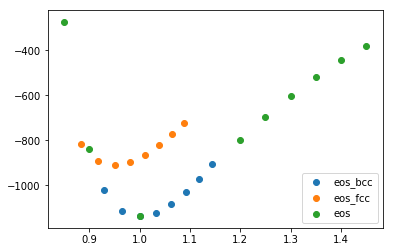

In [17]:
for key, trj in trjs.items():
    #print(i, list(zip(trj['atom_name'], trj['atom_num'])), len(trj['temp']))
    if 'eos' in key:
        plt.scatter([np.linalg.det(b)**(1./3.)/12.744894 for b in trj['box']][:-1], trj['energy'][:-1], label=key)
        print(trj['energy'][:])
plt.legend()
#plt.xlim(-1780,-1100)
plt.show()

In [18]:
def get_msd(xyzs):
    """Return mean squared displacement (msd) for a given trajectory (traj)."""
    msd = []
    for rs in xyzs:
        msd.append(np.mean((rs - xyzs[0])**2))
    #msd = [0.0 for _ in range(len(xyzs))]
    return np.array(msd)

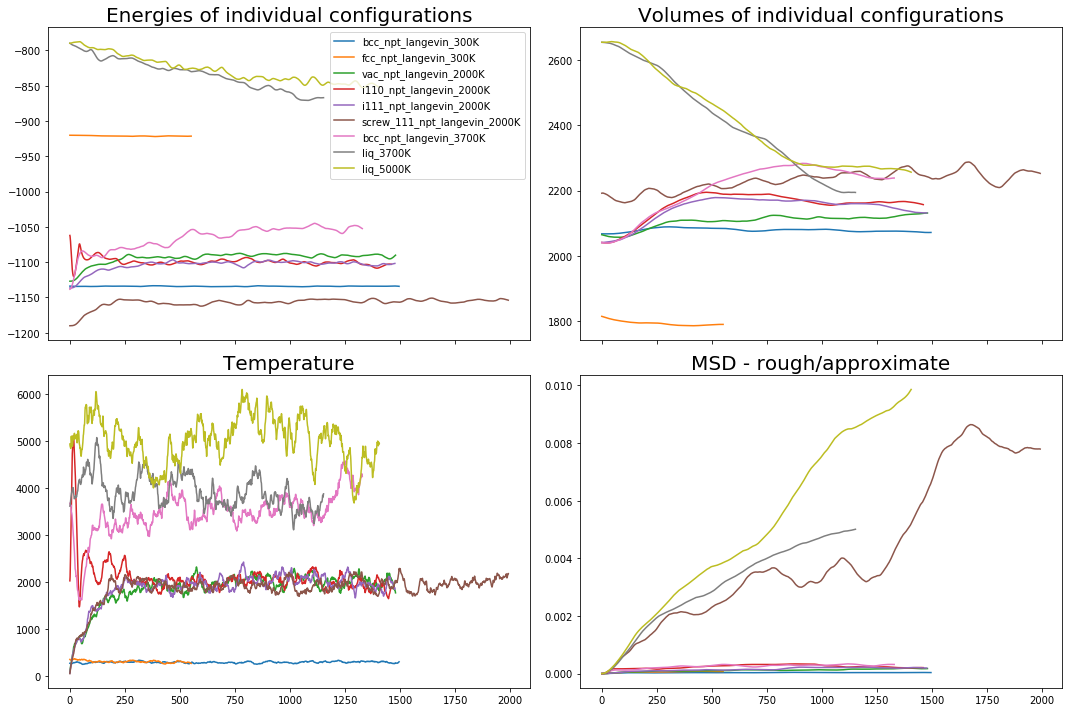

In [19]:
fig, axes = plt.subplots(2, 2, sharex='col', figsize=(15,10))

for key, traj in trjs.items():
    if 'relax' in key or 'eos' in key:
        continue

        
    #axes[0,0].plot([e/x.shape[0] for e, x in zip(traj['energy'], traj['xyz'])], label=dset)
    if 'screw' in key:
        axes[0,0].plot([e for e, x in zip(traj['energy'], traj['xyz'])], label=key)
        axes[0,1].plot([np.linalg.det(b) for b in traj['box']], label=key)
    else:
        axes[0,0].plot([e for e, x in zip(traj['energy'], traj['xyz'])], label=key)
        axes[0,1].plot([np.linalg.det(b) for b in traj['box']], label=key)


    axes[1,0].plot([t for t in traj['temp']], label=key)

    msd = get_msd(traj['xyz'])
    axes[1,1].plot(msd, label=key)

axes[0,0].legend()
axes[0,0].set_title('Energies of individual configurations', fontsize=20)
axes[0,1].set_title('Volumes of individual configurations', fontsize=20)       
axes[1,0].set_title('Temperature', fontsize=20)
axes[1,1].set_title('MSD - rough/approximate', fontsize=20)
fig.tight_layout()

In [20]:
[(k, len(v['energy'])) for k, v in trjs.items()]

[('bcc_npt_langevin_300K', 1496),
 ('fcc_npt_langevin_300K', 552),
 ('vac_npt_langevin_2000K', 1480),
 ('i110_npt_langevin_2000K', 1461),
 ('i111_npt_langevin_2000K', 1477),
 ('screw_111_npt_langevin_2000K', 1992),
 ('bcc_npt_langevin_3700K', 1329),
 ('liq_3700K', 1153),
 ('liq_5000K', 1406),
 ('relax', 7),
 ('eos_bcc', 9),
 ('eos_fcc', 9),
 ('eos', 10)]

In [21]:
slices = {'bcc_npt_langevin_300K':slice(500, None,5),
        'fcc_npt_langevin_300K':slice(50, None, 5),
        'vac_npt_langevin_2000K':slice(300, None, 5),
        'i110_npt_langevin_2000K':slice(1000, None, 5),
        'i111_npt_langevin_2000K':slice(1000, None, 5),
        'screw_111_npt_langevin_2000K':slice(1400, None, 5),
        'bcc_npt_langevin_3700K':slice(600, None, 5),
        'liq_3700K':slice(800, None, 5),
        'liq_5000K':slice(800, None, 5),
        'relax':slice(0, None, None),
        'eos_bcc':slice(0, None, None),
        'eos_fcc':slice(0, None, None),
        'eos':slice(0, None, None)
       }

In [22]:
trj_samples = {}
for key, traj in trjs.items():
    trj_samples[key] = traj[slices[key]]

In [23]:
[(k, len(v['energy'])) for k, v in trj_samples.items()]

[('bcc_npt_langevin_300K', 200),
 ('fcc_npt_langevin_300K', 101),
 ('vac_npt_langevin_2000K', 236),
 ('i110_npt_langevin_2000K', 93),
 ('i111_npt_langevin_2000K', 96),
 ('screw_111_npt_langevin_2000K', 119),
 ('bcc_npt_langevin_3700K', 146),
 ('liq_3700K', 71),
 ('liq_5000K', 122),
 ('relax', 7),
 ('eos_bcc', 9),
 ('eos_fcc', 9),
 ('eos', 10)]

In [24]:
# join 0 K configurations into a pseudo-trajectory
traj_md = copy.deepcopy(trj_samples['bcc_npt_langevin_300K'])

for k, trj in trj_samples.items():
    print(k)
    if 'eos' in k or 'relax' in k or 'bcc_npt_langevin_300K' in k: 
        continue
        
    traj_md.append(trj)

    print(len(traj_md['box']))

bcc_npt_langevin_300K
fcc_npt_langevin_300K
301
vac_npt_langevin_2000K
537
i110_npt_langevin_2000K
630
i111_npt_langevin_2000K
726
screw_111_npt_langevin_2000K
845
bcc_npt_langevin_3700K
991
liq_3700K
1062
liq_5000K
1184
relax
eos_bcc
eos_fcc
eos


In [25]:
trj_samples['eos_bcc'].append(trj_samples['eos'])

In [26]:
trj_samples['eos_bcc']['energy']

[-1139.1553999999999,
 -1022.8066999999999,
 -1114.8183999999999,
 -1123.9361,
 -1084.6381,
 -1031.6408,
 -971.3192999999999,
 -907.6867,
 -2.9688679595213743e-239,
 -1139.2,
 -271.8047221070888,
 -837.1711089986524,
 -800.6633444635341,
 -697.0611202328876,
 -602.3043063713139,
 -517.742999456512,
 -443.4032853774631,
 -378.657941519064,
 -2.9688679595213743e-239]

In [27]:
trj_fit = {'md':traj_md, 'relax':trj_samples['relax'], 'eos_bcc':trj_samples['eos_bcc'], 'eos_fcc':trj_samples['eos_fcc']}

In [28]:
trj_fit['md']['xyz'][-1].shape

(113, 3)

In [29]:
trj_fit.keys()

dict_keys(['md', 'relax', 'eos_bcc', 'eos_fcc'])

In [30]:
with open(os.path.join(working, "trj_fit.pickle"), 'wb') as fo:
    pickle.dump(trj_fit, fo)